In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import tensorflow as tf
print(tf.__version__)
import keras
print(keras.__version__)

/home/sunxin/miniconda3/envs/qinhanmin-test/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sunxin/miniconda3/envs/qinhanmin-test/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sunxin/miniconda3/envs/qinhanmin-test/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sunxin/minico

1.13.2
2.2.4


Using TensorFlow backend.


In [2]:
import numpy as np
from keras.applications import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras import models
from keras import layers
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
conv_base = VGG16(weights="imagenet", include_top=False, input_shape=(150, 150, 3))
conv_base.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
bloc

In [4]:
base_dir = '../cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')
datagen = ImageDataGenerator(rescale=1 / 255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [5]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 1s 461us/step - loss: 0.6052 - acc: 0.6600 - val_loss: 0.4673 - val_acc: 0.8070
Epoch 2/30
2000/2000 [==============================] - 1s 275us/step - loss: 0.4400 - acc: 0.8005 - val_loss: 0.3689 - val_acc: 0.8580
Epoch 3/30
2000/2000 [==============================] - 1s 279us/step - loss: 0.3601 - acc: 0.8445 - val_loss: 0.3197 - val_acc: 0.8840
Epoch 4/30
2000/2000 [==============================] - 1s 274us/step - loss: 0.3184 - acc: 0.8720 - val_loss: 0.2967 - val_acc: 0.8880
Epoch 5/30
2000/2000 [==============================] - 1s 284us/step - loss: 0.2847 - acc: 0.8860 - val_loss: 0.2849 - val_acc: 0.8890
Epoch 6/30
2000/2000 [==============================] - 1s 284us/step - loss: 0.2677 - acc: 0.8955 - val_loss

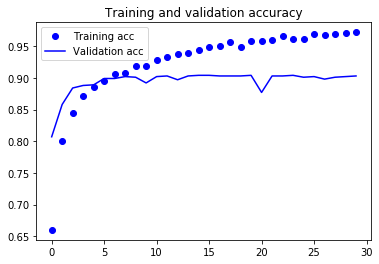

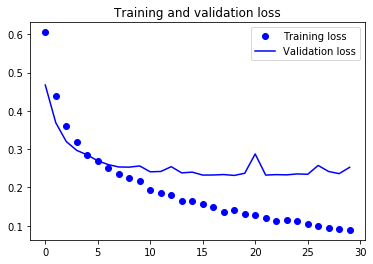

In [6]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.figure()
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [7]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [8]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))
conv_base.trainable = False
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30
This is the number of trainable weights after freezing the conv base: 4


In [9]:
train_datagen = ImageDataGenerator(
      rescale=1 / 255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1 / 255)
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')
model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
 - 13s - loss: 0.5922 - acc: 0.6895 - val_loss: 0.4476 - val_acc: 0.8360
Epoch 2/30
 - 11s - loss: 0.4706 - acc: 0.7935 - val_loss: 0.3659 - val_acc: 0.8530
Epoch 3/30
 - 11s - loss: 0.4295 - acc: 0.8105 - val_loss: 0.3562 - val_acc: 0.8550
Epoch 4/30
 - 11s - loss: 0.4041 - acc: 0.8275 - val_loss: 0.3072 - val_acc: 0.8850
Epoch 5/30
 - 11s - loss: 0.3788 - acc: 0.8345 - val_loss: 0.2927 - val_acc: 0.8830
Epoch 6/30
 - 11s - loss: 0.3610 - acc: 0.8485 - val_loss: 0.2814 - val_acc: 0.8910
Epoch 7/30
 - 11s - loss: 0.3371 - acc: 0.8645 - val_loss: 0.2867 - val_acc: 0.8870
Epoch 8/30
 - 11s - loss: 0.3493 - acc: 0.8520 - val_loss: 0.2670 - val_acc: 0.8960
Epoch 9/30
 - 11s - loss: 0.3430 - acc: 0.8490 - val_loss: 0.2601 - val_acc: 0.8990
Epoch 10/30
 - 11s - loss: 0.3374 - acc: 0.8540 - val_loss: 0.2611 - val_acc: 0.8980
Epoch 11/30
 - 11s - loss: 0.3202 - acc: 0.8645 - val_loss: 0.2610 - val_ac

In [10]:
model.save('cats_and_dogs_small_3.h5')

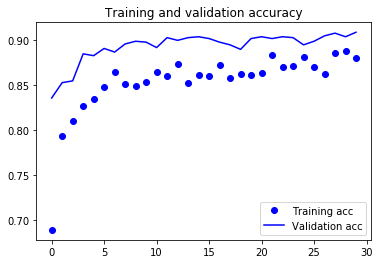

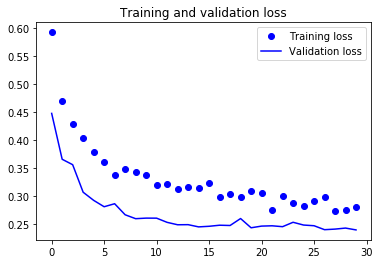

In [11]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.figure()
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Fine-tuning

In [12]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [13]:
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [14]:
model.compile(optimizer=optimizers.RMSprop(lr=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/100
100/100 [==============================] - 13s 126ms/step - loss: 0.2899 - acc: 0.8715 - val_loss: 0.2092 - val_acc: 0.9170
Epoch 2/100
100/100 [==============================] - 11s 114ms/step - loss: 0.2687 - acc: 0.8895 - val_loss: 0.2379 - val_acc: 0.9030
Epoch 3/100
100/100 [==============================] - 11s 113ms/step - loss: 0.2361 - acc: 0.9015 - val_loss: 0.2079 - val_acc: 0.9220
Epoch 4/100
100/100 [==============================] - 11s 114ms/step - loss: 0.2215 - acc: 0.9065 - val_loss: 0.2095 - val_acc: 0.9210
Epoch 5/100
100/100 [==============================] - 11s 115ms/step - loss: 0.2134 - acc: 0.9155 - val_loss: 0.2212 - val_acc: 0.9160
Epoch 6/100
100/100 [==============================] - 11s 114ms/step - loss: 0.1945 - acc: 0.9200 - val_loss: 0.2005 - val_acc: 0.9270
Epoch 7/100
100/100 [==============================] - 11s 114ms/step - loss: 0.1754 - acc: 0.9280 - val_loss: 0.1813 - val_acc: 0.9280
Epoch 8/100
100/100 [===========================

Epoch 61/100
100/100 [==============================] - 11s 115ms/step - loss: 0.0297 - acc: 0.9925 - val_loss: 0.3296 - val_acc: 0.9260
Epoch 62/100
100/100 [==============================] - 11s 113ms/step - loss: 0.0396 - acc: 0.9875 - val_loss: 0.2114 - val_acc: 0.9450
Epoch 63/100
100/100 [==============================] - 11s 113ms/step - loss: 0.0294 - acc: 0.9885 - val_loss: 0.3415 - val_acc: 0.9270
Epoch 64/100
100/100 [==============================] - 11s 113ms/step - loss: 0.0301 - acc: 0.9905 - val_loss: 0.2356 - val_acc: 0.9400
Epoch 65/100
100/100 [==============================] - 11s 114ms/step - loss: 0.0281 - acc: 0.9905 - val_loss: 0.3338 - val_acc: 0.9260
Epoch 66/100
100/100 [==============================] - 11s 114ms/step - loss: 0.0305 - acc: 0.9875 - val_loss: 0.2425 - val_acc: 0.9330
Epoch 67/100
100/100 [==============================] - 11s 113ms/step - loss: 0.0247 - acc: 0.9920 - val_loss: 0.2610 - val_acc: 0.9320
Epoch 68/100
100/100 [===================

In [15]:
model.save('cats_and_dogs_small_4.h5')

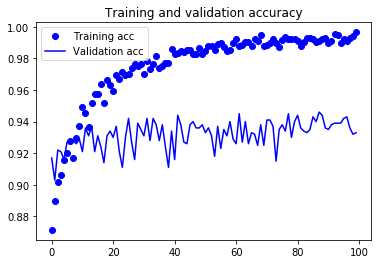

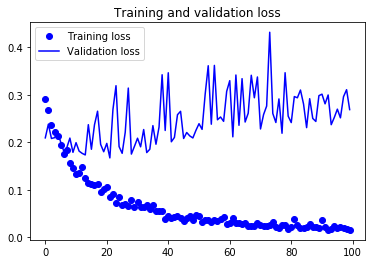

In [16]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.figure()
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

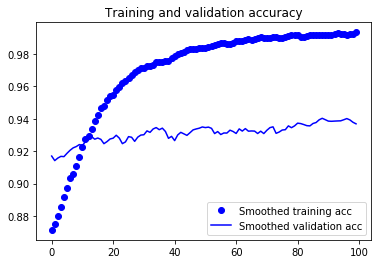

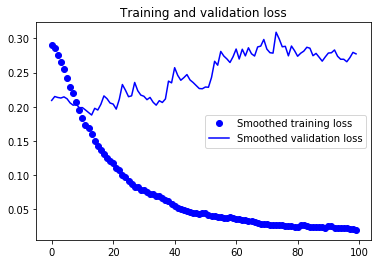

In [17]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

plt.figure()
plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [18]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.
test acc: 0.9419999945163727
